# DCGAN on Bricks Dataset

In [1]:
import os
from collections import defaultdict
from PIL import Image
import time
import numpy as np


import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as Transforms

from matplotlib import pyplot as plt

from torchsummary import summary
from torcheval import metrics as Metrics

## 0. Train Parameters

In [2]:
DATA_DIR = '../../data/Lego/dataset'
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
NOISE_PARAM = 0.1
EPOCHS = 300
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LR = 2e-4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

## 1. Prepare dataset

In [3]:
class LegoData(Dataset):

    def __init__(self, image_dir):
        super().__init__()
        self.image_dir = image_dir
        self.imgs = os.listdir(self.image_dir)
        self.length = len(self.imgs)

        # Define transforms
        self.transform = Transforms.Compose([
                            Transforms.ToTensor(),
                            Transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE), antialias=None),
                            Transforms.Grayscale(num_output_channels=1),
                            Transforms.Normalize((0.5), (0.5))])

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        img_file = os.path.join(self.image_dir, self.imgs[index])
        img = Image.open(img_file)
        img = self.transform(img)
        return img

In [4]:
def get_dataloader():
    lego_dataset = LegoData(DATA_DIR)
    train_loader = DataLoader(lego_dataset, batch_size=BATCH_SIZE, num_workers=8,
                              shuffle=True, pin_memory=True)
    print('Train data size: ', len(lego_dataset))
    print('Num. train batchs: ', len(train_loader))
    return train_loader

In [5]:
def display_imgs(imgs):
    plt.figure(figsize=(16, 3))
    for i in range(8):
        ax = plt.subplot(1, 8, i+1)
        ax.imshow(imgs[i][0], cmap='gray')
        ax.axis('off')
    plt.show()

Train data size:  40000
Num. train batchs:  313
torch.Size([128, 1, 64, 64])


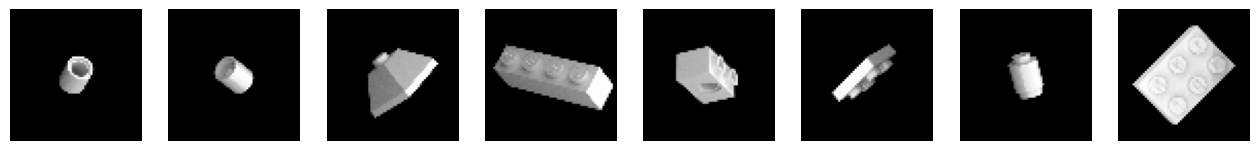

In [6]:
# Check dataset
train_loader = get_dataloader()
check_sample = next(iter(train_loader))
print(check_sample.shape)
display_imgs(check_sample)

## 2. Building GAN

In [7]:
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()

        channel_list = [CHANNELS, 64, 128, 256, 512]
        
        # Convolutional layers
        self.conv_layers = nn.Sequential()
        for i in range(len(channel_list) - 1):
            conv_block = self.get_conv_block(channel_list[i], channel_list[i+1], bool(i))
            self.conv_layers.add_module(f'conv_block_{i}', conv_block)

        # Layers for the output -> (Batch_size, 1)
        self.output_layers = nn.Sequential(
            nn.Conv2d(in_channels=channel_list[-1], out_channels=1, 
                      kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid(),
            nn.Flatten()
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.output_layers(x)
        return x    

    def get_conv_block(self, in_ch, out_ch, use_bn=False):
        conv_layer = nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=4,
                               stride=2, padding=1, bias=False)
        batch_norm = nn.BatchNorm2d(num_features=out_ch, momentum=0.1) # Note: Keras and PyTorch use momentum in different ways
        leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        dropout_2d = nn.Dropout2d(p=0.3)
        
        conv_block = [conv_layer, batch_norm, leaky_relu, dropout_2d] if use_bn else [conv_layer, leaky_relu, dropout_2d] 
        return nn.Sequential(*conv_block)

# test = Discriminator().to(DEVICE)
# summary(test, (1, 64, 64))

In [14]:
class Generator(nn.Module):

    def __init__(self, z_dim):
        super().__init__()
        channel_list = [z_dim, 512, 256, 128, 64]

        # Convolution transpose layers
        self.trans_conv_layers = nn.Sequential()
        for i in range(len(channel_list) - 1):
            stride = 2 if i else 1
            padding = 1 if i else 0
            trans_conv_block = self.get_transpose_conv_block(channel_list[i], channel_list[i + 1],
                                                             stride, padding)
            self.trans_conv_layers.add_module(f'trans_conv_block_{i}', trans_conv_block)

        # Output layers -> (-1, 1, 64, 64)
        self.output_layers = nn.Sequential(
                nn.ConvTranspose2d(in_channels=channel_list[-1], out_channels=CHANNELS,
                                   kernel_size=4, stride=2, padding=1, bias=False),
                nn.Tanh()
        )


    def forward(self, x):
        x = x.reshape(x.shape[0], x.shape[-1], 1, 1)
        x = self.trans_conv_layers(x)
        x = self.output_layers(x)
        return x

    
    def get_transpose_conv_block(self, in_ch, out_ch, stride=2, padding=1):
        transpose_conv = nn.ConvTranspose2d(in_channels=in_ch, out_channels=out_ch,
                                            kernel_size=4, stride=stride, padding=padding, bias=False)
        batch_norm = nn.BatchNorm2d(num_features=out_ch, momentum=0.1)
        leaky_relu = nn.LeakyReLU(negative_slope=0.2)
        return nn.Sequential(transpose_conv, batch_norm, leaky_relu)

# generator = Generator(Z_DIM).to(DEVICE)
# summary(generator, (100,))

In [15]:
# class DCGAN(nn.Module):
    
#     def __init__(self, z_dim):
#         super().__init__()
#         self.z_dim = z_dim
#         self.generator = Generator(z_dim)
#         self.discriminator = Discriminator()


#     def forward(self, real_imgs):
#         latents = torch.randn(size=(len(real_imgs), self.z_dim)).to(DEVICE)
#         generated_imgs = self.generator(latents)

#         real_preds = self.discriminator(real_imgs)
#         fake_preds = self.discriminator(generated_imgs)
        
#         return real_preds, fake_preds, generated_imgs

# dcgan = DCGAN(Z_DIM).to(DEVICE)
# summary(dcgan, (1, 64, 64))

## 3. Define the model, objective, and optimizer

In [29]:
net_D = Discriminator().to(DEVICE)
net_G = Generator(Z_DIM).to(DEVICE)


if torch.__version__.split('.')[0] == '2':
    torch.set_float32_matmul_precision('high')
    # It is important to use eager backend here to avoid
    # distribution mismatch in training and predicting
    net_D = torch.compile(net_D, backend='eager')
    net_G = torch.compile(net_G, backend='eager')
    print('model compiled')

loss_fn = nn.BCELoss()
d_optim = torch.optim.Adam(params=net_D.parameters(), lr=LR, betas=(ADAM_BETA_1, ADAM_BETA_2))
g_optim = torch.optim.Adam(params=net_G.parameters() ,lr=LR, betas=(ADAM_BETA_1, ADAM_BETA_2))

train_metrics = {
    'd_loss': Metrics.Mean(),
    'g_loss': Metrics.Mean(),
    'd_real_acc': Metrics.BinaryAccuracy(),
    'd_fake_acc': Metrics.BinaryAccuracy(),
    'g_acc': Metrics.BinaryAccuracy(),
}

model compiled


## 4. Get dataloader

In [30]:
lego_dataloader = get_dataloader()

Train data size:  40000
Num. train batchs:  313


## 5. Train step function

In [31]:
def train(net_D, net_G, dataloader, d_optim, g_optim, loss_fn, train_metrics):
    
    net_D.train() # Set model to train mode
    net_G.train()
    
    for metric in train_metrics.values():
        metric.reset() # clear metrics data

    for i, train_imgs in enumerate(dataloader):

        # 1. Update Discriminator
        
        # Train with real data
        net_D.zero_grad()
        train_imgs = train_imgs.to(DEVICE)
        real_pred = net_D(train_imgs)
        real_label = torch.ones_like(real_pred, dtype=torch.float)
        real_noisy_label = real_label + NOISE_PARAM * torch.randn(size=real_label.shape, device=DEVICE)

        d_real_loss = loss_fn(real_pred.reshape(-1), real_noisy_label.reshape(-1))
        d_real_loss.backward(retain_graph=True)

        # Generate fake batch
        noise = torch.randn(size=(len(train_imgs), Z_DIM), device=DEVICE)
        fake_imgs = net_G(noise)
        fake_pred = net_D(fake_imgs)
        fake_label = torch.zeros_like(fake_pred, dtype=torch.float)
        fake_noisy_label = fake_label - NOISE_PARAM * torch.randn(size=fake_label.shape, device=DEVICE)

        d_fake_loss = loss_fn(fake_pred.reshape(-1), fake_noisy_label.reshape(-1))
        d_fake_loss.backward(retain_graph=True)

        d_loss = d_fake_loss + d_real_loss
        d_optim.step()


        # 2. Update Generator
        net_G.zero_grad()
        fake_pred = net_D(fake_imgs)
        g_loss = loss_fn(fake_pred.reshape(-1), real_label.reshape(-1))
        g_loss.backward()
        g_optim.step()
    
        # Update metrics
        train_metrics['d_loss'].update(d_loss.detach().cpu())
        train_metrics['g_loss'].update(g_loss.detach().cpu())
        train_metrics['d_fake_acc'].update(fake_pred.reshape(-1).detach().cpu(), fake_label.reshape(-1).detach().cpu())
        train_metrics['d_real_acc'].update(real_pred.reshape(-1).detach().cpu(), real_label.reshape(-1).detach().cpu())
        train_metrics['g_acc'].update(fake_pred.reshape(-1).detach().cpu(), real_label.reshape(-1).detach().cpu())

        del d_loss, g_loss, fake_pred, real_pred, real_label, real_noisy_label, fake_label, fake_noisy_label 

    return fake_imgs

In [32]:
# train(net_D, net_G, lego_dataloader, d_optim, g_optim, loss_fn, train_metrics)

## 6. Train DCGAN

Epoch: 1	epoch time 0.40 min
	 d_loss: 0.3565 | g_loss: 8.0844 | d_real_acc: 0.9276 | d_fake_acc: 0.9840 | g_acc: 0.0160 | 


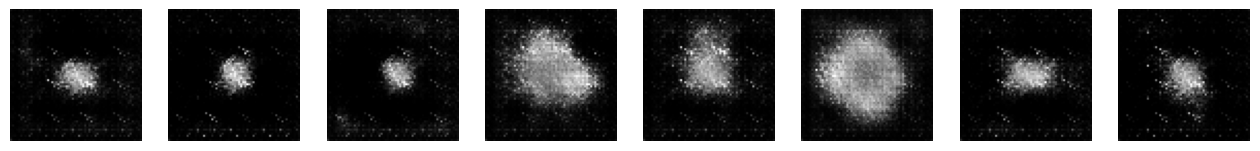

Epoch: 2	epoch time 0.37 min
	 d_loss: 0.9811 | g_loss: 2.2108 | d_real_acc: 0.7537 | d_fake_acc: 0.9271 | g_acc: 0.0729 | 
Epoch: 3	epoch time 0.37 min
	 d_loss: 0.9378 | g_loss: 2.1327 | d_real_acc: 0.7763 | d_fake_acc: 0.9022 | g_acc: 0.0978 | 
Epoch: 4	epoch time 0.37 min
	 d_loss: 0.8839 | g_loss: 2.1951 | d_real_acc: 0.7969 | d_fake_acc: 0.9086 | g_acc: 0.0914 | 
Epoch: 5	epoch time 0.38 min
	 d_loss: 0.7797 | g_loss: 2.4436 | d_real_acc: 0.8245 | d_fake_acc: 0.9238 | g_acc: 0.0762 | 
Epoch: 6	epoch time 0.37 min
	 d_loss: 0.6895 | g_loss: 2.6540 | d_real_acc: 0.8536 | d_fake_acc: 0.9279 | g_acc: 0.0721 | 
Epoch: 7	epoch time 0.36 min
	 d_loss: 0.6475 | g_loss: 2.7816 | d_real_acc: 0.8669 | d_fake_acc: 0.9348 | g_acc: 0.0652 | 
Epoch: 8	epoch time 0.36 min
	 d_loss: 0.5914 | g_loss: 2.8589 | d_real_acc: 0.8804 | d_fake_acc: 0.9436 | g_acc: 0.0564 | 
Epoch: 9	epoch time 0.37 min
	 d_loss: 0.6058 | g_loss: 3.0084 | d_real_acc: 0.8783 | d_fake_acc: 0.9422 | g_acc: 0.0578 | 
Epoch: 1

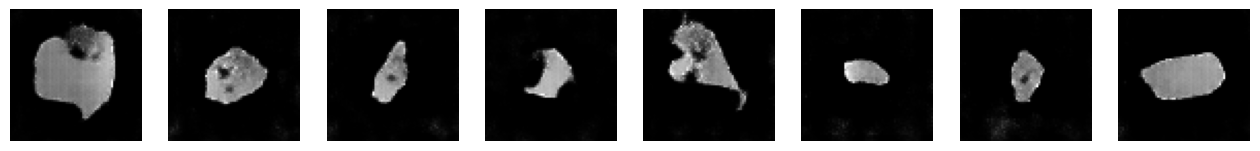

Epoch: 11	epoch time 0.37 min
	 d_loss: 0.5607 | g_loss: 3.1494 | d_real_acc: 0.8849 | d_fake_acc: 0.9332 | g_acc: 0.0668 | 
Epoch: 12	epoch time 0.37 min
	 d_loss: 0.5284 | g_loss: 3.1378 | d_real_acc: 0.8949 | d_fake_acc: 0.9361 | g_acc: 0.0639 | 
Epoch: 13	epoch time 0.36 min
	 d_loss: 0.4949 | g_loss: 3.3658 | d_real_acc: 0.9031 | d_fake_acc: 0.9438 | g_acc: 0.0562 | 
Epoch: 14	epoch time 0.37 min
	 d_loss: 0.5326 | g_loss: 3.3166 | d_real_acc: 0.8963 | d_fake_acc: 0.9369 | g_acc: 0.0631 | 
Epoch: 15	epoch time 0.38 min
	 d_loss: 0.5178 | g_loss: 3.3225 | d_real_acc: 0.8965 | d_fake_acc: 0.9359 | g_acc: 0.0641 | 
Epoch: 16	epoch time 0.37 min
	 d_loss: 0.4892 | g_loss: 3.3911 | d_real_acc: 0.9025 | d_fake_acc: 0.9379 | g_acc: 0.0621 | 
Epoch: 17	epoch time 0.37 min
	 d_loss: 0.4741 | g_loss: 3.4818 | d_real_acc: 0.9074 | d_fake_acc: 0.9472 | g_acc: 0.0528 | 
Epoch: 18	epoch time 0.37 min
	 d_loss: 0.4769 | g_loss: 3.5299 | d_real_acc: 0.9070 | d_fake_acc: 0.9452 | g_acc: 0.0548 | 


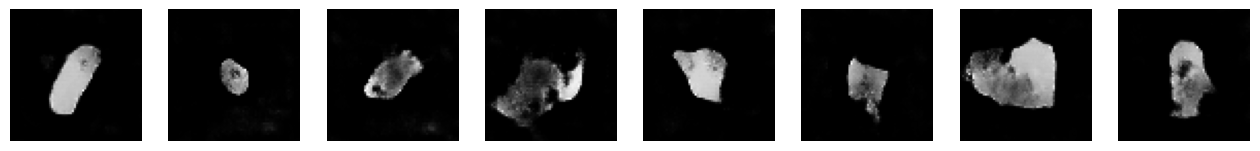

In [ ]:
history = defaultdict(list)

for i in range(EPOCHS):
    prev_time = time.time()
    generated_imgs = train(net_D, net_G, lego_dataloader, d_optim, g_optim, loss_fn, train_metrics)
    curr_time = time.time()
    
    for key, value in train_metrics.items():
        history[key].append(value.compute().item())
    
    print('Epoch: {}\tepoch time {:.2f} min'.format(i+1, (curr_time - prev_time) / 60))
    metrics = [f'{key}: {value.compute().item():.4f} | ' for key, value in train_metrics.items()]
    print('\t', ''.join(metrics))

    if i == 0 or (i + 1) % 10 == 0:
        generated_imgs = generated_imgs.detach().cpu()
        display_imgs(generated_imgs)